In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
from time import time

from useful_functions import load_transform_split, color_scatter, scatter_predvreal, get_metric
from RandomSeedSearchCV import RandomSeedSearchCV, randomseed_rfr_maker

from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
import pickle

from joblib import dump,load

In [2]:
X_train,X_test,y_train,y_test,pipeline = load_transform_split(target='DROPOUT_N',
                                                              expand=False,
                                                              clean=True,
                                                              split=0.2,
                                                              return_pipeline=True,
                                                              fmt='numpy',
                                                              random_state=42)

y_train = y_train.flatten()
y_test  = y_test.flatten()

[[3.47100000e+03 1.89706446e+00 1.63076187e+00 2.09368404e+00
  2.26635933e+00]
 [5.96900000e+03 1.96120979e+00 1.67688156e+00 2.08966467e+00
  3.88698411e+00]
 [4.27600000e+03 1.98765065e+00 1.71321809e+00 2.13145699e+00
  2.67601562e+00]
 ...
 [9.28800000e+03 4.36254887e+00 4.37550905e+00 5.36353215e+00
  3.25449944e-01]
 [6.87300000e+03 4.36314719e+00 4.24079090e+00 5.21482693e+00
  5.75656176e-01]
 [1.89000000e+03 4.36711260e+00 4.44808549e+00 5.44441971e+00
  3.41629505e-01]]


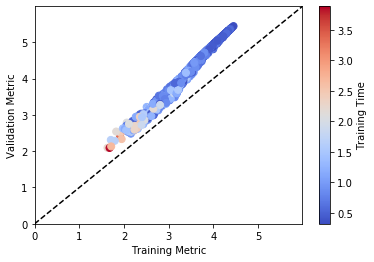

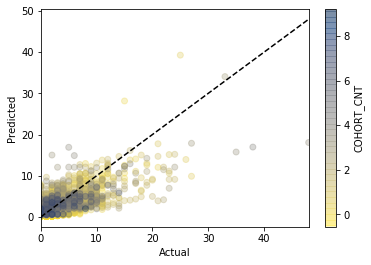

In [5]:
#CAUTION: This cell takes awhile unless you make N smaller.

#Searching through RandomForestRegressor models.
tbl = RandomSeedSearchCV(randomseed_rfr_maker,X_train,y_train,N=1000,shield_seed=True,random_state=42,n_jobs=3)
print(tbl)

#Get best model.
best_seed = int(tbl[0,0])
best_model = randomseed_rfr_maker(best_seed)

#Plot goodness-of-fit
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
scatter_predvreal(y_test,y_pred,colorby=X_test[:,0])

In [15]:
mse = get_metric('mean_squared_error')

print("Best RFR: Train RMSE = %.2f, Test RMSE = %.2f"%(
                               np.sqrt(mse(best_model,X_train,y_train)),
                               np.sqrt(mse(best_model,X_test,y_test)),
                               ))

Best RFR, Train RMSE = 1.29, Test RMSE = 1.40


In [17]:
#Store random search output and pickle best model.
np.savetxt("RFR_randomseedsearch.out",tbl,header='seed  cv_score  training_mse  validation_mse  training_time(s)')
dump(best_model, 'saved_models/best_RandomForestRegressor_DROPOUT_N.joblib') 

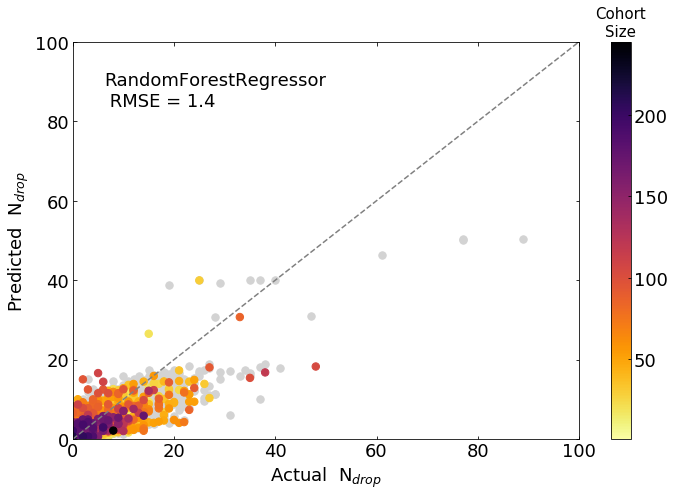

In [39]:
#Make a pretty plot for checkpoint.

plt.rcParams.update({
                     'xtick.direction':'in',
                     'xtick.top':True,
                     'xtick.bottom':True,
                     'ytick.direction':'in',
                     'ytick.right':True,
                     'ytick.left':True,
})
model = load('saved_models/best_RandomForestRegressor_DROPOUT_N.joblib')

#Load data without pipeline to get un-scaled cohort counts for colorbar.
tra,tes  = load_transform_split(target=None,
                                expand=False,
                                clean=False,
                                split=0.2,
                                return_pipeline=False,
                                fmt='pandas',
                                random_state=42)
COHORT_CNT_tes = tes['COHORT_CNT'].to_numpy()

#Plot goodness-of-fit
fig,ax=plt.subplots(figsize=(10,7))
fs = 18
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
ax,cbar = color_scatter(y_train,y_pred,colorby=None,alpha=1,s=55,color='lightgray',ax=ax)
y_pred = model.predict(X_test)
cmap = plt.get_cmap('inferno_r')
ax,cbar = color_scatter(y_test,y_pred,colorby=COHORT_CNT_tes,alpha=1,s=55,cmap=cmap,ax=ax)
ma=100
ax.plot([0,ma],[0,ma],ls='--',color='gray')
ax.set_xlim(0,ma)
ax.set_ylim(0,ma)
ax.set_xlabel('Actual  N$_{drop}$',fontsize=fs)
ax.set_ylabel('Predicted  N$_{drop}$',fontsize=fs)
cbar.ax.set_title('Cohort\nSize',fontsize=15)
for tlab in ax.get_xticklabels()+ax.get_yticklabels()+cbar.ax.get_yticklabels():
    tlab.set_fontsize(fs)
calc_mse = get_metric('mean_squared_error')
rmse = np.sqrt(calc_mse(model,X_test,y_test))
ax.figure.text(0.15,0.85,"RandomForestRegressor\n RMSE = %.1f"%(rmse),fontsize=fs,horizontalalignment='left',verticalalignment='top')

plt.tight_layout()
ax.figure.savefig('figures/rfr_summary.png',dpi=450)

-15.0 6.760660417405229
ABS
-15.0 14.283081067372038
ABS
-15.0 12.006348609924316
ABS


/home/richseif/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


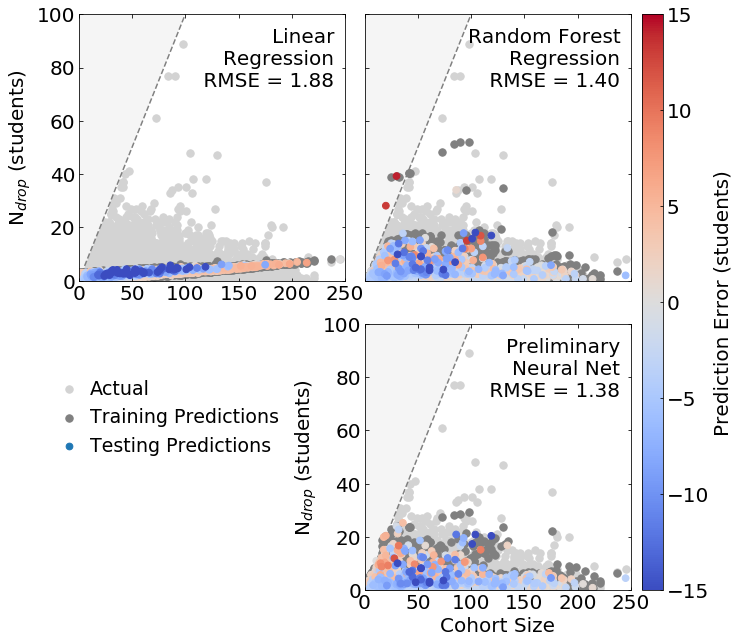

In [4]:
#Make a pretty plot for checkpoint.

plt.rcParams.update({
                     'xtick.direction':'in',
                     'xtick.top':True,
                     'xtick.bottom':True,
                     'ytick.direction':'in',
                     'ytick.right':True,
                     'ytick.left':True,
})
def staggering_beauty(model,name,refit=False,ax=None,
                      colorbar=True,cax=None,cmap='coolwarm',
                      legend=True,fs=20):
    #Load data without pipeline to get un-scaled cohort counts for colorbar.
    tra,tes  = load_transform_split(target=None,
                                    expand=False,
                                    clean=False,
                                    split=0.2,
                                    return_pipeline=False,
                                    fmt='pandas',
                                    random_state=42)
    COHORT_CNT_tes = tes['COHORT_CNT'].to_numpy()
    COHORT_CNT_tra = tra['COHORT_CNT'].to_numpy()

    if ax is None:
        fig,ax=plt.subplots(figsize=(10,7))
    if refit:
        model.fit(X_train,y_train)

    ax,cbar = color_scatter(np.append(COHORT_CNT_tra,COHORT_CNT_tes),np.append(y_train,y_test),colorby=None,alpha=1,s=55,color='lightgray',label='Actual',ax=ax,zorder=0)
    tri = plt.Polygon([[0,0],[0,200],[200,201.5]], color='whitesmoke',zorder=0)
    ax.add_patch(tri)


    y_pred = model.predict(X_train).flatten()
    ax,cbar = color_scatter(COHORT_CNT_tra,y_pred,colorby=None,alpha=1,s=55,color='gray',label='Training Predictions',ax=ax)

    y_pred = model.predict(X_test).flatten()
    cmap = plt.get_cmap(cmap)
    pe_lim = 15
    perc_error = (y_pred-y_test)
    badmask = np.isnan(perc_error) | np.isinf(perc_error)
    perc_error[badmask] = pe_lim*np.sign(y_pred[badmask])
    perc_error[perc_error> pe_lim] = pe_lim
    perc_error[perc_error<-pe_lim] = -pe_lim
    print(np.nanmin(perc_error),np.nanmax(perc_error))
    ax,cbar = color_scatter(COHORT_CNT_tes,y_pred,colorby=perc_error,
                            alpha=1,s=45,cmap=cmap,ax=ax,vmin=-pe_lim,vmax=pe_lim,
                            sortabs=True,label='Testing Predictions',colorbar=colorbar,cax=cax)
    ma=250
    ax.plot([0,ma],[0,ma],ls='--',color='gray',zorder=0)
    ax.set_xlim(0,250)
    ax.set_ylim(0,100)
    ax.set_xlabel('Cohort Size',fontsize=fs)
    ax.set_ylabel('N$_{drop}$ (students)',fontsize=fs)
    if colorbar:
        cbar.ax.set_ylabel('Prediction Error (students)',fontsize=fs)
        for tlab in cbar.ax.get_yticklabels():
            tlab.set_fontsize(fs)
    for tlab in ax.get_xticklabels()+ax.get_yticklabels():
        tlab.set_fontsize(fs)
    calc_mse = get_metric('mean_squared_error')
    rmse = np.sqrt(calc_mse(model,X_test,y_test))
    ax.text(240,95,"%s\n RMSE = %.2f"%(name,rmse),fontsize=fs,horizontalalignment='right',verticalalignment='top')
    if legend:
        ax.legend(loc=(0.55,0.7),fontsize=fs-3,frameon=False)
    return ax
    

rfr = load('saved_models/best_RandomForestRegressor_DROPOUT_N.joblib')
lin = LinearRegression()
ann = keras.models.load_model("saved_models/good_neual_net.h5")
ann = keras.models.load_model("better_neural_net.h5")

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.093,0.55,0.37,0.37])
ax2 = fig.add_axes([0.49,0.55,0.37,0.37])
#ax3 = fig.add_axes([0.09,0.12,0.37,0.37])
ax4 = fig.add_axes([0.49,0.12,0.37,0.37])
cax = fig.add_axes([0.875,0.12,0.03,0.8])



#model = pickle.load('good_neural_net')
staggering_beauty(lin,'Linear\nRegression',refit=True,ax=ax1,colorbar=False,legend=False)
staggering_beauty(rfr,'Random Forest\nRegression',ax=ax2,colorbar=False,legend=False)
ax = staggering_beauty(ann,'Preliminary\nNeural Net',ax=ax4,colorbar=True,cax=cax,legend=False)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax2.set_xticklabels([])
ax2.set_ylabel('')
ax2.set_yticklabels([])
ax.legend(loc = 'center',frameon=False,bbox_to_anchor=(-.75,0.65),fontsize=19,handletextpad=0.1)
plt.tight_layout()
fig.savefig('figures/all_summary.png',dpi=450)

#### Try going back to DROPOUT_RATE (instead of DROPOUT_N) just to see if it works. (It doesn't)

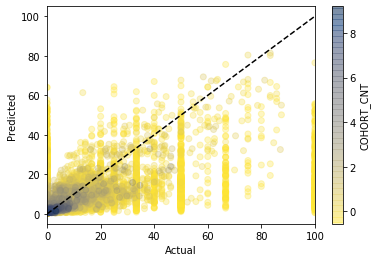

In [3]:
### Try training the best DROPOUT_N model on DROPOUT_RATE data... I wonder if it could do it.

model = load('saved_models/best_RandomForestRegressor_DROPOUT_N.joblib')

X_train,X_test,y_train,y_test,pipeline = load_transform_split(target='DROPOUT_RATE',
                                                              expand=False,
                                                              clean=True,
                                                              split=0.2,
                                                              return_pipeline=True,
                                                              fmt='numpy',
                                                              random_state=42)
y_train = y_train.flatten()
y_test  = y_test.flatten()

model.fit(X_train,y_train)

#Plot goodness-of-fit
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
scatter_predvreal(y_test,y_pred,colorby=X_test[:,0])

#Lol no it can not.

[[3.60000000e+01 3.18403326e+02 2.83559380e+02 3.12193819e+02
  3.05108404e+00]
 [3.91000000e+02 3.18789898e+02 2.86936811e+02 3.12471655e+02
  1.87521982e+00]
 [1.75000000e+02 3.18830724e+02 2.93137270e+02 3.11185808e+02
  7.43316650e-01]
 [1.79000000e+02 3.19820108e+02 2.99431336e+02 3.14083760e+02
  3.87101412e+00]
 [9.00000000e+02 3.19967301e+02 3.05217078e+02 3.12688605e+02
  1.88178134e+00]
 [3.06000000e+02 3.20068604e+02 2.88011526e+02 3.13422845e+02
  1.44665098e+00]
 [2.79000000e+02 3.20091924e+02 3.02636779e+02 3.14885794e+02
  1.13615465e+00]
 [4.24000000e+02 3.20428836e+02 2.89862964e+02 3.15262004e+02
  9.23047543e-01]
 [1.14000000e+02 3.20613376e+02 3.05456828e+02 3.13724359e+02
  1.05789924e+00]
 [4.00000000e+02 3.20656113e+02 2.98661971e+02 3.14842284e+02
  2.96793318e+00]
 [5.43000000e+02 3.20806140e+02 2.72480835e+02 3.13963686e+02
  4.17859054e+00]
 [6.97000000e+02 3.21105134e+02 2.75420194e+02 3.13955114e+02
  5.39102221e+00]
 [6.86000000e+02 3.21137814e+02 2.968177

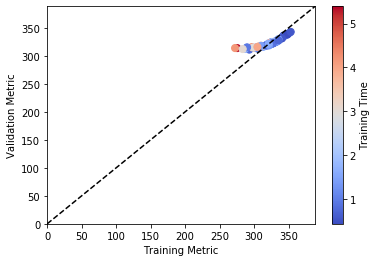

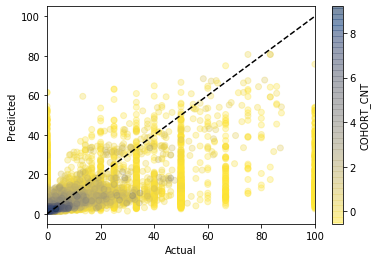

In [4]:
#CAUTION: This cell takes awhile unless you make N smaller.

#Searching through RandomForestRegressor models.
tbl = RandomSeedSearchCV(randomseed_rfr_maker,X_train,y_train,N=100,shield_seed=True,random_state=42,n_jobs=3)
print(tbl)

#Get best model.
best_seed = int(tbl[0,0])
best_model = randomseed_rfr_maker(best_seed)

#Plot goodness-of-fit
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
scatter_predvreal(y_test,y_pred,colorby=X_test[:,0])

In [23]:
COHORT_CNT_tes

array(['M', 'M', 'F', ..., 'F', 'M', 'F'], dtype=object)

In [30]:
plt.rcParams.keys()

/home/richseif/anaconda3/lib/python3.7/_collections_abc.py:705: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  return '{0.__class__.__name__}({0._mapping!r})'.format(self)


KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [56]:
max(y_train)

89.0

<IPython.core.display.Javascript object>


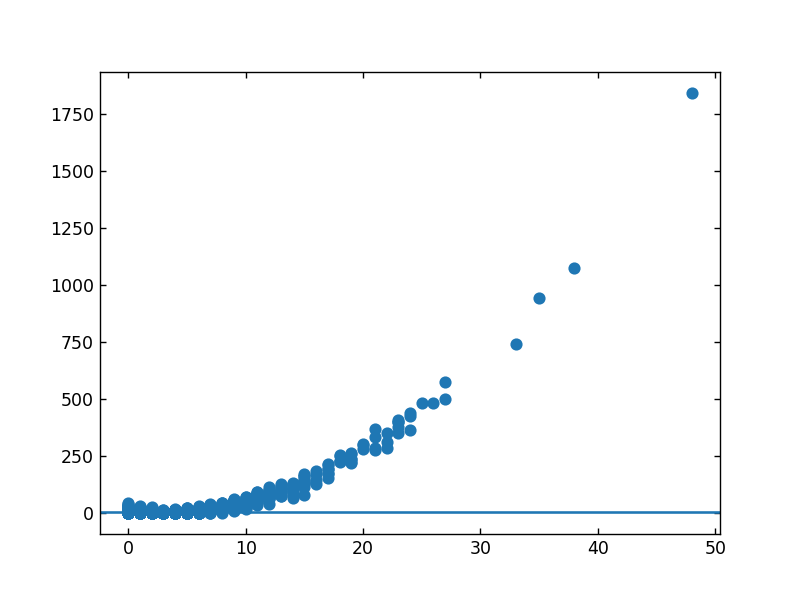

1.8769695259438768


In [76]:
model.fit(X_train,y_train)#,sample_weight=COHORT_CNT_tra)
y_pred = model.predict(X_test)
fig,ax = plt.subplots()
se = (y_pred-y_test)**2
ax.scatter(y_test,(y_pred-y_test)**2)
ax.axhline(np.mean(se))
print(np.mean(se)**0.5)